In [79]:
# Load libraries
import os
import numpy as np
import cv2
import tensorflow as tf 
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import glob
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, MaxPool2D
from tensorflow.keras.utils import to_categorical, normalize

In [80]:
glioma = []
meninglioma = []
no_tumor = []
pitutary = []

glioma_path = 'image_dataset/Training/glioma_tumor/*.jpg'
meninglioma_path = 'image_dataset/Training/meningioma_tumor/*.jpg'
no_tumor_path = 'image_dataset/Training/no_tumor/*.jpg'
pitutary_path = 'image_dataset/Training/pituitary_tumor/*.jpg'

for f in glob.glob(glioma_path):
    img = cv2.imread(f)
    glioma.append(img)

for f in glob.glob(meninglioma_path):
    img = cv2.imread(f)
    meninglioma.append(img)

for f in glob.glob(no_tumor_path):
    img = cv2.imread(f)
    no_tumor.append(img)

for f in glob.glob(pitutary_path):
    img = cv2.imread(f)
    pitutary.append(img)

len(glioma), len(meninglioma), len(no_tumor), len(pitutary)


KeyboardInterrupt: 

In [ ]:
glioma_test = []
meninglioma_test = []
no_tumor_test = []
pitutary_test = []

glioma_test_path = 'image_dataset/Training/glioma_tumor/*.jpg'
meninglioma_test_path = 'image_dataset/Training/meningioma_tumor/*.jpg'
no_tumor_test_path = 'image_dataset/Training/no_tumor/*.jpg'
pitutary_test_path = 'image_dataset/Training/pituitary_tumor/*.jpg'

for f in glob.glob(glioma_test_path):
    img = cv2.imread(f)
    glioma_test.append(img)

for f in glob.glob(meninglioma_test_path):
    img = cv2.imread(f)
    meninglioma_test.append(img)

for f in glob.glob(no_tumor_test_path):
    img = cv2.imread(f)
    no_tumor_test.append(img)

for f in glob.glob(pitutary_test_path):
    img = cv2.imread(f)
    pitutary_test.append(img)

len(glioma_test), len(meninglioma_test), len(no_tumor_test), len(pitutary_test)

In [4]:
# Crop images

def crop_countour(images, plot = False):
    new_images = []
    for image in images:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)
        thresh1 = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh1 = cv2.erode(thresh1, None, iterations=2)
        thresh1 = cv2.dilate(thresh1, None, iterations=2)

        contour = cv2.findContours(thresh1.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contour = contour[0] if len(contour) == 2 else contour[1]
        c = max(contour, key=cv2.contourArea)
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]].copy()

        if plot:
            plt.figure()
            plt.subplot(1, 2, 1)
            plt.imshow(image)
            plt.title('Original Image')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(new_image)
            plt.title('Cropped Image')
            plt.axis('off')
            
        new_images.append(new_image)

    return new_images
    

In [5]:
# Resize all images to the target shape
glioma = crop_countour(glioma, plot = False)
meninglioma = crop_countour(meninglioma, plot = False)
no_tumor = crop_countour(no_tumor, plot = False)
pitutary = crop_countour(pitutary, plot = False)

glioma_test = crop_countour(glioma_test, plot = False)
meninglioma_test = crop_countour(meninglioma_test, plot = False)
no_tumor_test = crop_countour(no_tumor_test, plot = False)
pitutary_test = crop_countour(pitutary_test, plot = False)


In [ ]:
# Define the target shape for resizing images
target_shape = (256, 256)

# Function to resize images
def resize_images(image_list, target_shape):
	resized_images = []
	for img in image_list:
		resized_img = cv2.resize(img, target_shape)
		resized_images.append(resized_img)
	return np.array(resized_images)


# Resize all images to the target shape
glioma = resize_images(glioma, target_shape)
meninglioma = resize_images(meninglioma, target_shape)
no_tumor = resize_images(no_tumor, target_shape)
pitutary = resize_images(pitutary, target_shape)

all_images = np.concatenate((glioma, meninglioma, no_tumor, pitutary), axis=0)

glioma_test = resize_images(glioma_test, target_shape)
meninglioma_test = resize_images(meninglioma_test, target_shape)
no_tumor_test = resize_images(no_tumor_test, target_shape)
pitutary_test = resize_images(pitutary_test, target_shape)

all_images_test = np.concatenate((glioma_test, meninglioma_test, no_tumor_test, pitutary_test), axis=0)

all_images.shape, all_images_test.shape

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(all_images[i])

In [ ]:
def plot_random(glioma, meninglioma, pitutary, no_tumor, num=5):
    healthy_img = no_tumor[np.random.choice(no_tumor.shape[0], num, replace=False)]
    glioma_img = glioma[np.random.choice(glioma.shape[0], num, replace=False)]
    meninglioma_img = meninglioma[np.random.choice(meninglioma.shape[0], num, replace=False)]
    pitutary_img = pitutary[np.random.choice(pitutary.shape[0], num, replace=False)]

    plt.figure(figsize=(10, 10))
    for i in range(num):
        plt.subplot(4, num, i + 1)
        plt.imshow(healthy_img[i])
        plt.title('No Tumor')
        plt.axis('off')

        plt.subplot(4, num, i + num + 1)
        plt.imshow(glioma_img[i])
        plt.title('Glioma')
        plt.axis('off')

        plt.subplot(4, num, i + 2*num + 1)
        plt.imshow(meninglioma_img[i])
        plt.title('Meninglioma')
        plt.axis('off')

        plt.subplot(4, num, i + 3*num + 1)
        plt.imshow(pitutary_img[i])
        plt.title('Pitutary')
        plt.axis('off')

plot_random(glioma, meninglioma, pitutary, no_tumor)

In [9]:
# Define the dataset class
# The dataset class should inherit from torch.utils.data.Dataset
# The __init__ method should accept the data and labels as arguments
# The __len__ method should return the length of the dataset
# The __getitem__ method should return a dictionary containing the data and the label
# The normalize method should normalize the data
# label 0: glioma, label 1: meninglioma, label 2: pitutary, label 3: no_tumor

class MRIDataset(Dataset):
    def __init__(self, glioma, meninglioma, pitutary, no_tumor, transform=None):
        self.images = np.concatenate((glioma, meninglioma, pitutary, no_tumor), axis=0)
        self.labels = np.concatenate((
            np.zeros(len(glioma), dtype=float), 
            np.ones(len(meninglioma),dtype=float), 
            np.full(len(pitutary), 2, dtype=float), 
            np.full(len(no_tumor), 3, dtype=float)
        ), axis=0)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return {'image': image, 'label': label}

    def normalize(self):
        return normalize(self.images, axis=1)
    
    def to_categorical(self):
        return to_categorical(self.labels, num_classes=4)
    


In [ ]:
# Create an instance of the dataset
dataset = MRIDataset(glioma, meninglioma, pitutary, no_tumor)
test_dataset = MRIDataset(glioma_test, meninglioma_test, pitutary_test, no_tumor_test)

len(dataset)

In [ ]:
dataset.normalize()  
test_dataset.normalize()

dataset.to_categorical()
test_dataset.to_categorical()

In [12]:
dataloader  = DataLoader(dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(dataset.images, dataset.labels, test_size=0.2, random_state=42, shuffle=True)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

In [14]:
#Model

In [20]:

earlystopping = EarlyStopping(monitor="val_loss", 
                              mode="min", 
                              patience=5, 
                              restore_best_weights = True)

In [29]:
model = Sequential()

model.add(Conv2D(8, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), kernel_initializer='he_uniform', activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(4, activation='softmax'))


d:\Anaconda\envs\Tensorflow\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 127, 127, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 127, 127, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 32)   │         2,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 8)              │             

 Total params: 14,791,052 (56.42 MB)

 Trainable params: 14,790,380 (56.42 MB)

 Non-trainable params: 672 (2.62 KB)

In [32]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True,
    show_layer_names=True,
)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [33]:
model.fit(X_train, y_train, 
          epochs=10, 
          batch_size=64, 
          validation_data=(X_val, y_val), 
          shuffle=False,
          verbose=1,
          callbacks=[earlystopping])

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 33s 811ms/step - accuracy: 0.4034 - loss: 1.4407 - val_accuracy: 0.1829 - val_loss: 8.7370
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 28s 781ms/step - accuracy: 0.5896 - loss: 0.9321 - val_accuracy: 0.3415 - val_loss: 1.3471
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 28s 781ms/step - accuracy: 0.6580 - loss: 0.8174 - val_accuracy: 0.3153 - val_loss: 1.4602
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 28s 787ms/step - accuracy: 0.7397 - loss: 0.6735 - val_accuracy: 0.6498 - val_loss: 0.8941
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 26s 732ms/step - accuracy: 0.8024 - loss: 0.5592 - val_accuracy: 0.5540 - val_loss: 1.0364
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 27s 740ms/step - accuracy: 0.8356 - loss: 0.4948 - val_accuracy: 0.6899 - val_loss: 0.7913
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 29s 796ms/step - accuracy: 0.8797 - loss: 0.3940 - val_accuracy: 0.7491 - val_loss: 0.7026
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 29s 791ms/step - accuracy: 0.8944 - loss: 0.3558 - val_accu

In [34]:
# Test against test dataset

y_pred = model.predict(test_dataset.images)
y_pred = np.argmax(y_pred, axis=1)

acc = accuracy_score(test_dataset.labels, y_pred)
cm = confusion_matrix(test_dataset.labels, y_pred)
cr = classification_report(test_dataset.labels, y_pred)

90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step


Next model

In [35]:
print(f'Accuracy: {acc}')
print(f'Confusion Matrix: \n{cm}')
print(f'Classification Report: \n{cr}')

Accuracy: 0.9355400696864111
Confusion Matrix: 
[[802  22   1   1]
 [ 52 731  11  28]
 [ 34   4 785   4]
 [ 12  14   2 367]]
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.89      0.97      0.93       826
         1.0       0.95      0.89      0.92       822
         2.0       0.98      0.95      0.97       827
         3.0       0.92      0.93      0.92       395

    accuracy                           0.94      2870
   macro avg       0.93      0.93      0.93      2870
weighted avg       0.94      0.94      0.94      2870



In [54]:
keras.models.save_model(model, 'model.h5')

In [36]:
model1 = Sequential()

model1.add(InputLayer(input_shape=(256,256,3)))

model1.add(Conv2D(filters=8,kernel_size=3, activation="relu", padding="same"))
model1.add(MaxPool2D())

model1.add(Conv2D(filters=64,kernel_size=3, activation="relu", padding="same"))
model1.add(MaxPool2D())

model1.add(Flatten())

model1.add(Dense(128, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(rate=0.3))

model1.add(Dense(32, activation="relu"))
model1.add(BatchNormalization())
model1.add(Dropout(rate=0.3))

model1.add(Dense(4, activation="softmax"))

model1.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

d:\Anaconda\envs\Tensorflow\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [37]:
model1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 256, 256, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 128, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 64)   │         4,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │    33,554,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,564,356 (128.04 MB)

 Trainable params: 33,564,036 (128.04 MB)

 Non-trainable params: 320 (1.25 KB)

In [38]:
tf.keras.utils.plot_model(
    model, to_file='model1.png', show_shapes=True,
    show_layer_names=True,
)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [39]:
history = model1.fit(X_train, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    shuffle=True,
                    callbacks=[earlystopping])

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 645ms/step - accuracy: 0.4505 - loss: 1.4728 - val_accuracy: 0.1359 - val_loss: 17.7881
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 623ms/step - accuracy: 0.6508 - loss: 0.9281 - val_accuracy: 0.1394 - val_loss: 4.7076
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 23s 623ms/step - accuracy: 0.6743 - loss: 0.8733 - val_accuracy: 0.5453 - val_loss: 1.1737
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 615ms/step - accuracy: 0.7814 - loss: 0.5916 - val_accuracy: 0.3833 - val_loss: 1.9849
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 618ms/step - accuracy: 0.8366 - loss: 0.4832 - val_accuracy: 0.5906 - val_loss: 1.0913
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 620ms/step - accuracy: 0.8778 - loss: 0.3652 - val_accuracy: 0.6272 - val_loss: 0.9763
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 23s 625ms/step - accuracy: 0.9028 - loss: 0.2958 - val_accuracy: 0.7143 - val_loss: 0.7759
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 621ms/step - accuracy: 0.9311 - loss: 0.2341 - val_acc

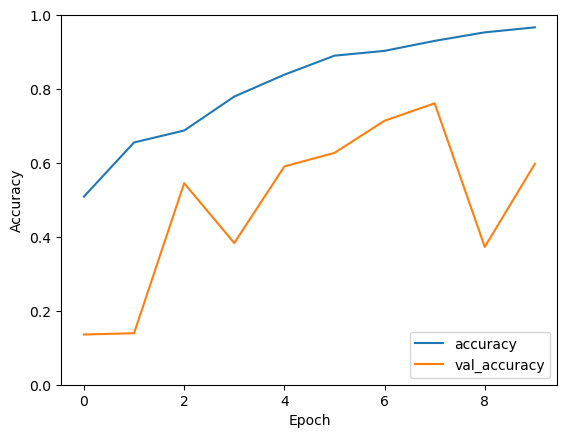

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

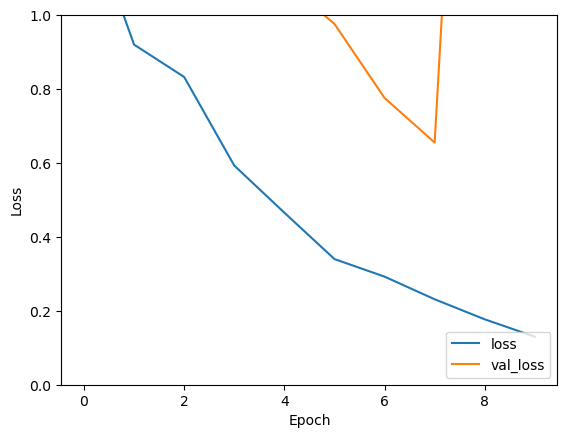

In [42]:
# Loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [43]:
# Test against test dataset
y_pred = model1.predict(test_dataset.images)
y_pred = np.argmax(y_pred, axis=1)

print(accuracy_score(test_dataset.labels, y_pred))
print(confusion_matrix(test_dataset.labels, y_pred))
print(classification_report(test_dataset.labels, y_pred))

90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step
0.8811846689895471
[[792  23  10   1]
 [ 35 747  38   2]
 [  7   3 817   0]
 [ 50 126  46 173]]
              precision    recall  f1-score   support

         0.0       0.90      0.96      0.93       826
         1.0       0.83      0.91      0.87       822
         2.0       0.90      0.99      0.94       827
         3.0       0.98      0.44      0.61       395

    accuracy                           0.88      2870
   macro avg       0.90      0.82      0.84      2870
weighted avg       0.89      0.88      0.87      2870



next model

In [ ]:
model2 = Sequential()

model2.add(InputLayer(input_shape=(256,256,3)))

model2.add(Conv2D(filters=8,kernel_size=3, activation="relu", padding="same"))
model2.add(MaxPool2D())

model2.add(Conv2D(filters=64,kernel_size=3, activation="relu", padding="same"))
model2.add(MaxPool2D())

model2.add(Conv2D(filters=256,kernel_size=3, activation="relu", padding="same"))
model2.add(MaxPool2D())

model2.add(Flatten())

model2.add(Dense(128, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(rate=0.25))

model2.add(Dense(32, activation="relu"))
model2.add(BatchNormalization())
model2.add(Dropout(rate=0.3))

model2.add(Dense(16, activation="relu"))
model2.add(BatchNormalization())
model2.add(Dropout(rate=0.3))

model2.add(Dense(4, activation="softmax"))

model2.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

d:\Anaconda\envs\Tensorflow\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [53]:
model2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 256, 256, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 128, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 128, 128, 64)   │         4,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 64, 64, 256)    │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │    33,554,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,712,596 (128.60 MB)

 Trainable params: 33,712,244 (128.60 MB)

 Non-trainable params: 352 (1.38 KB)

In [46]:
tf.keras.utils.plot_model(
    model, to_file='model1.png', show_shapes=True,
    show_layer_names=True,
)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [47]:
earlystopping = EarlyStopping(monitor="val_loss", 
                                        mode="min", 
                                        patience=5, 
                                        restore_best_weights = True)

history2 = model.fit(X_train, y_train, 
          epochs=10, 
          batch_size=64, 
          validation_data=(X_val, y_val), 
          shuffle=False,
          verbose=1,
          callbacks=[earlystopping])

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 27s 750ms/step - accuracy: 0.9483 - loss: 0.2276 - val_accuracy: 0.7125 - val_loss: 0.8217
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 28s 785ms/step - accuracy: 0.9576 - loss: 0.1939 - val_accuracy: 0.7666 - val_loss: 0.7335
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 28s 785ms/step - accuracy: 0.9541 - loss: 0.1752 - val_accuracy: 0.7631 - val_loss: 0.7237
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 28s 786ms/step - accuracy: 0.9728 - loss: 0.1451 - val_accuracy: 0.8240 - val_loss: 0.5538
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 28s 784ms/step - accuracy: 0.9743 - loss: 0.1300 - val_accuracy: 0.8328 - val_loss: 0.5254
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 28s 790ms/step - accuracy: 0.9707 - loss: 0.1333 - val_accuracy: 0.6864 - val_loss: 1.1779
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 28s 784ms/step - accuracy: 0.9772 - loss: 0.1151 - val_accuracy: 0.8066 - val_loss: 0.5790
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 28s 786ms/step - accuracy: 0.9762 - loss: 0.1078 - val_accu

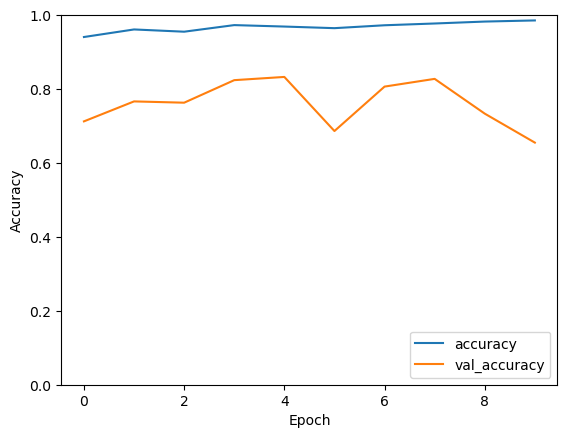

In [48]:
# Accuracy
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

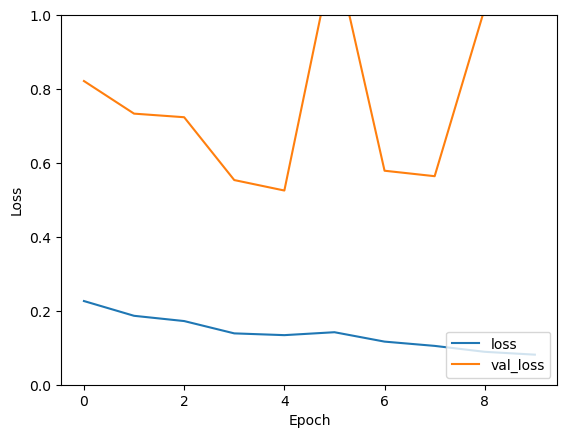

In [49]:
# Loss
plt.plot(history2.history['loss'], label='loss')
plt.plot(history2.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [ ]:
# Test against test dataset

y_pred = model2.predict(test_dataset.images)
y_pred = np.argmax(y_pred, axis=1)

print(accuracy_score(test_dataset.labels, y_pred))
print(confusion_matrix(test_dataset.labels, y_pred))
print(classification_report(test_dataset.labels, y_pred))

90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step
0.2951219512195122
[[765  29   0  32]
 [740  56   0  26]
 [762  25   0  40]
 [319  50   0  26]]
              precision    recall  f1-score   support

         0.0       0.30      0.93      0.45       826
         1.0       0.35      0.07      0.11       822
         2.0       0.00      0.00      0.00       827
         3.0       0.21      0.07      0.10       395

    accuracy                           0.30      2870
   macro avg       0.21      0.27      0.17      2870
weighted avg       0.21      0.30      0.18      2870



d:\Anaconda\envs\Tensorflow\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Anaconda\envs\Tensorflow\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Anaconda\envs\Tensorflow\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Next model

In [68]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (InputLayer, Conv2D, MaxPooling2D, Reshape, 
                                     SimpleRNN, LSTM, Flatten, Dense, BatchNormalization, Dropout)
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)              │ (None, 256, 256, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 128, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 128, 128, 64)   │         4,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 64, 4096)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 64, 128)        │       540,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 606,132 (2.31 MB)

 Trainable params: 605,844 (2.31 MB)

 Non-trainable params: 288 (1.12 KB)

None
Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 566ms/step - accuracy: 0.2560 - loss: 2.0113 - val_accuracy: 0.1986 - val_loss: 2.2732
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 592ms/step - accuracy: 0.2966 - loss: 1.7742 - val_accuracy: 0.1794 - val_loss: 2.2942
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 583ms/step - accuracy: 0.2894 - loss: 1.7352 - val_accuracy: 0.2822 - val_loss: 1.5546
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 582ms/step - accuracy: 0.2990 - loss: 1.5975 - val_accuracy: 0.1533 - val_loss: 1.7510
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 591ms/step - accuracy: 0.3262 - loss: 1.4262 - val_accuracy: 0.2247 - val_loss: 1.4817
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 589ms/step - accuracy: 0.3423 - loss: 1.4120 - val_accuracy: 0.2700 - val_loss: 1.4516
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 583ms/step - accuracy: 0.3616 - loss: 1.4088 - val_accuracy: 0.3206 - val_loss: 1.3281
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 589ms/step - accuracy: 0.3295 - loss: 1.4211 - val

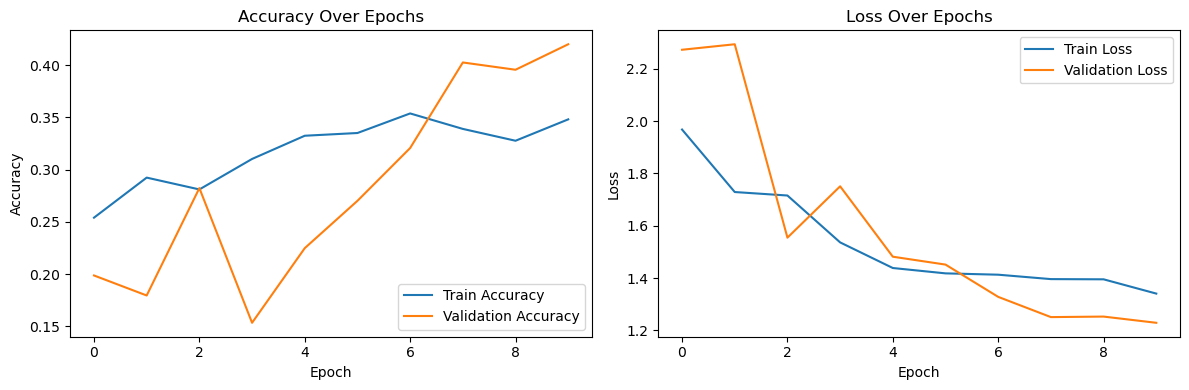

90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step
Test Accuracy: 0.3909407665505226
Confusion Matrix:
 [[651  18 155   2]
 [392  94 264  72]
 [519  35 266   7]
 [115  95  74 111]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.39      0.79      0.52       826
         1.0       0.39      0.11      0.18       822
         2.0       0.35      0.32      0.34       827
         3.0       0.58      0.28      0.38       395

    accuracy                           0.39      2870
   macro avg       0.43      0.38      0.35      2870
weighted avg       0.40      0.39      0.35      2870



In [71]:


# Define input shape and number of classes based on your dataset
input_shape = (256, 256, 3)
num_classes = 4  # Updated to 4 classes since your labels go from 0 to 3

# Build the model
model3 = Sequential()
model3.add(InputLayer(input_shape=input_shape))

# --- Feature Extraction with Convolutions ---
model3.add(Conv2D(filters=8, kernel_size=3, activation="relu", padding="same"))
model3.add(MaxPooling2D(pool_size=(2, 2)))  # Reduces spatial dimensions

model3.add(Conv2D(filters=64, kernel_size=3, activation="relu", padding="same"))
model3.add(MaxPooling2D(pool_size=(2, 2)))
# After three poolings on a 256x256 image, the spatial dimensions reduce roughly to 32x32.

# --- Reshape for Recurrent Layers ---
# We reshape the feature maps into a sequence.
# For example, if our feature maps are (32, 32, 64) then we reshape to (32, 32*64) per time step.
# Calculate the correct dimensions after the convolution and pooling layers
# Initial input shape is (256, 256, 3)
# After first Conv2D and MaxPooling2D: (128, 128, 8)
# After second Conv2D and MaxPooling2D: (64, 64, 64)
model3.add(Reshape((64, 64 * 64)))  # Sequence length = 64, feature dimension = 64*64

# --- Recurrent Processing ---
# Process the sequence with a SimpleRNN layer
model3.add(SimpleRNN(128, activation="relu", return_sequences=True))
# Follow with an LSTM layer; returning only the final output vector.
model3.add(LSTM(64, activation="relu", return_sequences=False))

# --- Classification Head ---
# The LSTM layer output is already 1D, so we can directly add Dense layers.
model3.add(Dense(128, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.3))

model3.add(Dense(16, activation="relu"))
model3.add(BatchNormalization())
model3.add(Dropout(0.3))

# Final output layer with softmax activation for multi-class classification.
model3.add(Dense(num_classes, activation="softmax"))

# Compile the model using sparse categorical crossentropy for integer labels.
model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display the model architecture
print(model3.summary())

# --- Training Setup ---
# Early stopping callback to prevent overfitting.
earlystopping = EarlyStopping(monitor="val_loss", 
                              mode="min", 
                              patience=5, 
                              restore_best_weights=True)

# Assume X_train, y_train, X_val, y_val are your preprocessed training and validation datasets.
history = model3.fit(X_train, y_train, 
                    epochs=10, 
                    batch_size=128, 
                    validation_data=(X_val, y_val), 
                    shuffle=True,
                    verbose=1,
                    callbacks=[earlystopping])

# --- Plotting Training History ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# --- Evaluation on Test Data ---
# Suppose test_dataset.images and test_dataset.labels contain your test images and corresponding labels.
y_pred = model3.predict(test_dataset.images)
y_pred = tf.argmax(y_pred, axis=1).numpy()  # Convert probabilities to predicted class indices

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print("Test Accuracy:", accuracy_score(test_dataset.labels, y_pred))
print("Confusion Matrix:\n", confusion_matrix(test_dataset.labels, y_pred))
print("Classification Report:\n", classification_report(test_dataset.labels, y_pred))


In [75]:
def train_and_run(model3, batch_size=128, epochs=10):
    # Compile the model using sparse categorical crossentropy for integer labels.
    model3.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    # Display the model architecture
    print(model3.summary())

    # --- Training Setup ---
    # Early stopping callback to prevent overfitting.
    earlystopping = EarlyStopping(monitor="val_loss", 
                                mode="min", 
                                patience=5, 
                                restore_best_weights=True)

    # Assume X_train, y_train, X_val, y_val are your preprocessed training and validation datasets.
    history = model3.fit(X_train, y_train, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_data=(X_val, y_val), 
                        shuffle=True,
                        verbose=1,
                        callbacks=[earlystopping])

    # --- Plotting Training History ---
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    # --- Evaluation on Test Data ---
    # Suppose test_dataset.images and test_dataset.labels contain your test images and corresponding labels.
    y_pred = model3.predict(test_dataset.images)
    y_pred = tf.argmax(y_pred, axis=1).numpy()  # Convert probabilities to predicted class indices

    from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
    print("Test Accuracy:", accuracy_score(test_dataset.labels, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(test_dataset.labels, y_pred))
    print("Classification Report:\n", classification_report(test_dataset.labels, y_pred))

Next Model

In [73]:
model4 = Sequential()

model4.add(Conv2D(8, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model4.add(MaxPooling2D((2, 2)))
model4.add(BatchNormalization())
model4.add(Dropout(0.1))

model4.add(Conv2D(64, (3, 3), kernel_initializer='he_uniform', activation='relu'))
model4.add(MaxPooling2D((2, 2)))
model4.add(BatchNormalization())
model4.add(Dropout(0.1))

model4.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model4.add(MaxPooling2D((2, 2)))
model4.add(BatchNormalization())
model4.add(Dropout(0.1))

model4.add(Flatten())

model4.add(Dense(128, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.15))

model4.add(Dense(32, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.15))

model4.add(Dense(32, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.2))

model4.add(Dense(8, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.2))

model4.add(Dense(4, activation='softmax'))


d:\Anaconda\envs\Tensorflow\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)              │ (None, 254, 254, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 127, 127, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 127, 127, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 127, 127, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 125, 125, 64)   │         4,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 62, 62, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 32)             │             

 Total params: 14,831,564 (56.58 MB)

 Trainable params: 14,830,764 (56.57 MB)

 Non-trainable params: 800 (3.12 KB)

None
Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.3693 - loss: 1.4245 - val_accuracy: 0.1376 - val_loss: 38.9336
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.5326 - loss: 1.1031 - val_accuracy: 0.1376 - val_loss: 13.7580
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.6017 - loss: 0.9843 - val_accuracy: 0.1376 - val_loss: 6.0862
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.6448 - loss: 0.9048 - val_accuracy: 0.2108 - val_loss: 3.3171
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.7214 - loss: 0.7725 - val_accuracy: 0.3014 - val_loss: 1.7842
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.7573 - loss: 0.7071 - val_accuracy: 0.4077 - val_loss: 1.3432
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.8031 - loss: 0.6239 - val_accuracy: 0.6498 - val_loss: 0.9538
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.8376 - loss: 0.5332 - val_accuracy: 0.7108 - va

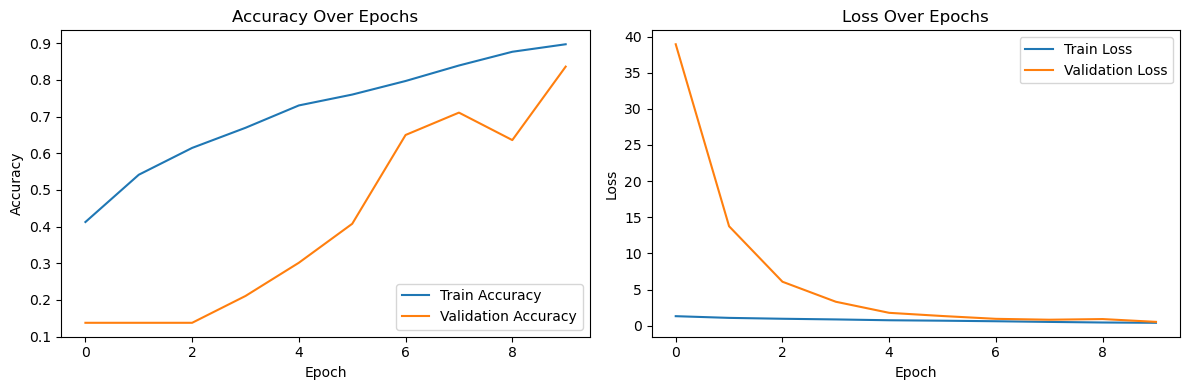

90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step
Test Accuracy: 0.9320557491289199
Confusion Matrix:
 [[790  17  17   2]
 [ 28 704  41  49]
 [ 22   1 798   6]
 [  3   6   3 383]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.96      0.95       826
         1.0       0.97      0.86      0.91       822
         2.0       0.93      0.96      0.95       827
         3.0       0.87      0.97      0.92       395

    accuracy                           0.93      2870
   macro avg       0.93      0.94      0.93      2870
weighted avg       0.93      0.93      0.93      2870



In [74]:
train_and_run(model4, 128, 10)

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)              │ (None, 254, 254, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 127, 127, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 127, 127, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 127, 127, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 125, 125, 64)   │         4,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 62, 62, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 32)             │             

 Total params: 14,831,564 (56.58 MB)

 Trainable params: 14,830,764 (56.57 MB)

 Non-trainable params: 800 (3.12 KB)

None
Epoch 1/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8289 - loss: 0.5222 - val_accuracy: 0.5453 - val_loss: 1.1103
Epoch 2/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.8674 - loss: 0.4169 - val_accuracy: 0.5714 - val_loss: 1.4369
Epoch 3/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.8655 - loss: 0.4191 - val_accuracy: 0.7631 - val_loss: 0.7770
Epoch 4/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9273 - loss: 0.2685 - val_accuracy: 0.8467 - val_loss: 0.5422
Epoch 5/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9332 - loss: 0.2458 - val_accuracy: 0.8519 - val_loss: 0.5100
Epoch 6/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9549 - loss: 0.1870 - val_accuracy: 0.8328 - val_loss: 0.5280
Epoch 7/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.9579 - loss: 0.1590 - val_accuracy: 0.3937 - val_loss: 2.7127
Epoch 8/15
36/36 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.9706 - loss: 0.1369 - val_accuracy: 0.6010 - val_

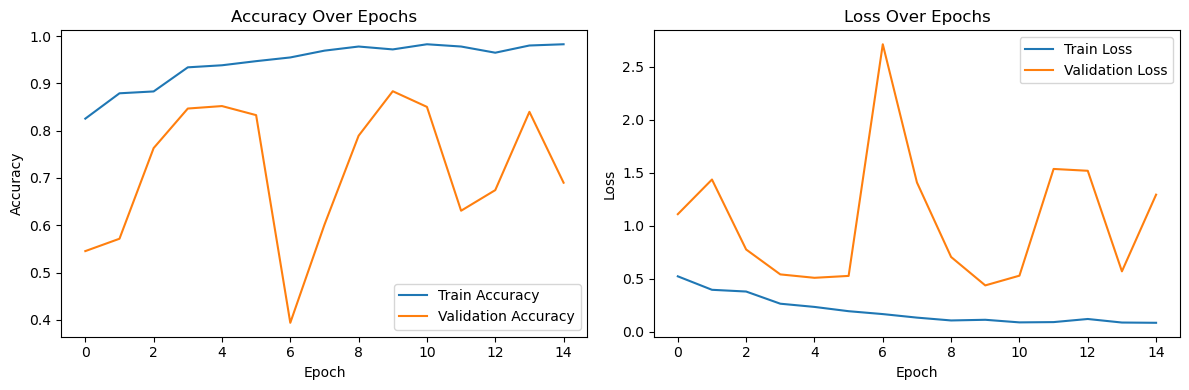

90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step
Test Accuracy: 0.9700348432055749
Confusion Matrix:
 [[816   7   1   2]
 [ 31 766  10  15]
 [  1   6 819   1]
 [  4   6   2 383]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.99      0.97       826
         1.0       0.98      0.93      0.95       822
         2.0       0.98      0.99      0.99       827
         3.0       0.96      0.97      0.96       395

    accuracy                           0.97      2870
   macro avg       0.97      0.97      0.97      2870
weighted avg       0.97      0.97      0.97      2870



In [76]:
train_and_run(model4, 64, 15)

Next model

In [81]:
keras.models.save_model(model4, 'model4_97.h5')

In [77]:
model5 = Sequential()

model5.add(Conv2D(8, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model5.add(MaxPooling2D((2, 2)))
model5.add(BatchNormalization())
model5.add(Dropout(0.1))

model5.add(Conv2D(64, (3, 3), kernel_initializer='he_uniform', activation='relu'))
model5.add(MaxPooling2D((2, 2)))
model5.add(BatchNormalization())
model5.add(Dropout(0.1))

model5.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model5.add(MaxPooling2D((2, 2)))
model5.add(BatchNormalization())
model5.add(Dropout(0.1))

model5.add(Flatten())

model5.add(Dense(128, activation='relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.15))

model5.add(Dense(64, activation='relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.15))

model5.add(Dense(64, activation='relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.2))

model5.add(Dense(16, activation='relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.2))

model5.add(Flatten())

model5.add(Dense(4, activation='softmax'))

d:\Anaconda\envs\Tensorflow\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_45 (Conv2D)              │ (None, 254, 254, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 127, 127, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 127, 127, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 127, 127, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 125, 125, 64)   │         4,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 62, 62, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 64)             │             

 Total params: 14,839,892 (56.61 MB)

 Trainable params: 14,838,948 (56.61 MB)

 Non-trainable params: 944 (3.69 KB)

None
Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.3730 - loss: 1.4592 - val_accuracy: 0.1847 - val_loss: 13.2535
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6114 - loss: 0.9407 - val_accuracy: 0.1359 - val_loss: 8.8139
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.6740 - loss: 0.8156 - val_accuracy: 0.1376 - val_loss: 4.3573
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7533 - loss: 0.6737 - val_accuracy: 0.1359 - val_loss: 2.9629
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8238 - loss: 0.5195 - val_accuracy: 0.1376 - val_loss: 2.3950
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8625 - loss: 0.4205 - val_accuracy: 0.1934 - val_loss: 1.9780
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8768 - loss: 0.3750 - val_accuracy: 0.3624 - val_loss: 1.9156
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.9155 - loss: 0.2938 - val_accuracy: 0.3589 - val

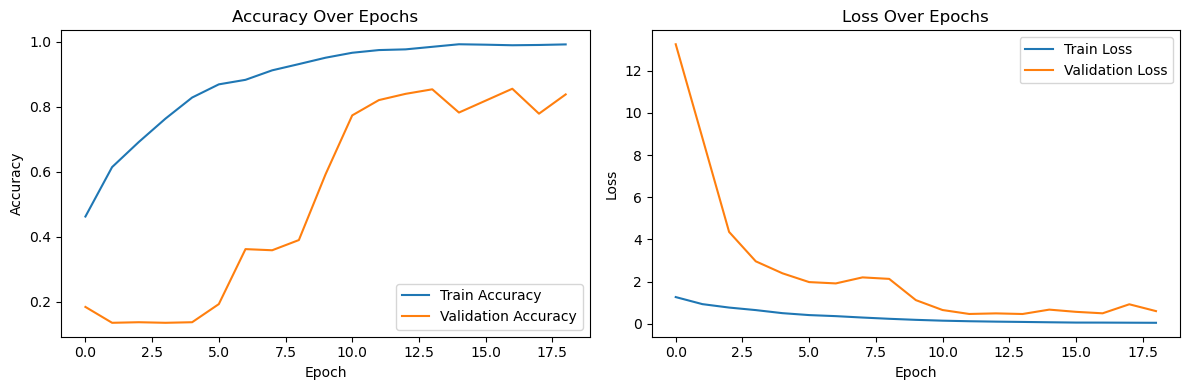

90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step
Test Accuracy: 0.9682926829268292
Confusion Matrix:
 [[800  22   2   2]
 [ 19 781   8  14]
 [  7   6 812   2]
 [  0   8   1 386]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       826
         1.0       0.96      0.95      0.95       822
         2.0       0.99      0.98      0.98       827
         3.0       0.96      0.98      0.97       395

    accuracy                           0.97      2870
   macro avg       0.97      0.97      0.97      2870
weighted avg       0.97      0.97      0.97      2870



In [78]:
train_and_run(model5, 128, 20)